# Two Sigma Connect - Rental Listing Inqueries

[Kaggle link](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries)

In [3]:
%matplotlib inline

# Base dependencies
import json
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import os
import pandas as pd
import pickle
import requests
import scipy.sparse as sp
import seaborn as sns
import uuid

# Machine learning / stats dependencies
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import KNeighborsClassifier

# Image processing dependencies
from PIL import Image
from StringIO import StringIO

# Neighborhood dependencies
from geopy.geocoders import Nominatim

# Suppress annoying deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Read in the training data
train_df = pd.read_json("train.json")

# Business Understanding

### What problem are we trying solve?
* RentHop is an apartment search website. We are trying to predict the interest level (high, medium, low) of a new listing.
* RentHop could use the model developed in this exercise to improve the quality of search results and therefore increase the frequency of bookings.
* In addition, our analytic might help RentHop better handle fraud control, identify potential listing quality issues, and allow owners and agents to better understand renters’ needs and preferences.

### What are the relevant metrics? How much do we plan to improve them?
* The evaluation metric is the multiclass loss, essentially logloss for 3 interest levels.
* A baseline prediction of 0.33 for each class will result in a loss of 1.1. We plan on reducing the logloss to 0.7 or lower (or a prediction of 0.5 for the correct class, an almost 50% increase in confidence from the baseline prediction)

### What will we deliver?
* A categorical response prediction model for predicting the interest level of an apartment listing.
* This prediction will primarily be used to rank apartments from the RentHop search page. 

# Data Understanding

### What are the raw data sources?
* The training data provided are raw listing details, provided in JSON format by RentHop.

### What does each 'unit' (e.g. row) of data represent?
* Each row is an apartment listing, containing internal apartment characteristics (like number of bathrooms) and contextual metadata (like lat-lon and street address)

### What are the fields (columns)?
* Dependent variable: 
    - *interest_level (categorical)*: 'High', 'Medium', or 'Low' rental interest, calculated by RentHop using an algorithm undisclosed to the public
* Independent variable: 
    - *bathrooms (numeric)*: Number of bathrooms in the unit
    - *bedrooms (numeric)*: Number of bedrooms in the unit
    - *building_id (categorical)*: Unique ID for particular building
    - *created (date_string)*: Date the listing was first created on RentHop
    - *description (string)*: Open-text description of the unit, provided by the listing author
    - *display_address (string)*: Marketing-friendly address (not strictly a Post Office address) like "Studio at 5528-5532 S. Everett Avenue"
    - *features (string)*: Semi-structured list of features like "gas stove" and "air conditioning"
    - *latitude (numeric)*: Latitude of the listed property
    - *longitude (numeric)*: Longitude of the listed property
    - *listing_id (categorical)*: Unique ID for a particular listing
    - *manager_id (categorical)*: Unique ID for a building manager
    - *photos (list of strings)*: List of URLs to listing photos on RentHop
    - *price (numeric)*: Monthly rent price (in USD)
    - *street_address (string)*: Actual street address of the listed property

In [6]:
# Show col names
train_df.columns

Index([u'bathrooms', u'bedrooms', u'building_id', u'created', u'description',
       u'display_address', u'features', u'interest_level', u'latitude',
       u'listing_id', u'longitude', u'manager_id', u'photos', u'price',
       u'street_address'],
      dtype='object')

### EDA
* Missing values

In [7]:
np.sum(train_df.isnull().any(axis=1)) # there are no missing values

0

* Distribution of target
    * There are about 70% low interest, 23% medium interest and 8% high interest

In [8]:
print "raw counts of targets: "
print train_df.interest_level.value_counts()

print "\n\npercentages for targets: "
print train_df.interest_level.value_counts() * 100.0 / train_df.shape[0]

raw counts of targets: 
low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64


percentages for targets: 
low       69.468309
medium    22.752877
high       7.778813
Name: interest_level, dtype: float64


* Distribution of each feature
    * Numerical features

In [9]:
# description of numerical features
train_df.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,price
count,49352.00000,49352.000000,49352.000000,4.935200e+04,49352.000000,4.935200e+04
mean,1.21218,1.541640,40.741545,7.024055e+06,-73.955716,3.830174e+03
std,0.50142,1.115018,0.638535,1.262746e+05,1.177912,2.206687e+04
min,0.00000,0.000000,0.000000,6.811957e+06,-118.271000,4.300000e+01
25%,1.00000,1.000000,40.728300,6.915888e+06,-73.991700,2.500000e+03
50%,1.00000,1.000000,40.751800,7.021070e+06,-73.977900,3.150000e+03
75%,1.00000,2.000000,40.774300,7.128733e+06,-73.954800,4.100000e+03
max,10.00000,8.000000,44.883500,7.753784e+06,0.000000,4.490000e+06


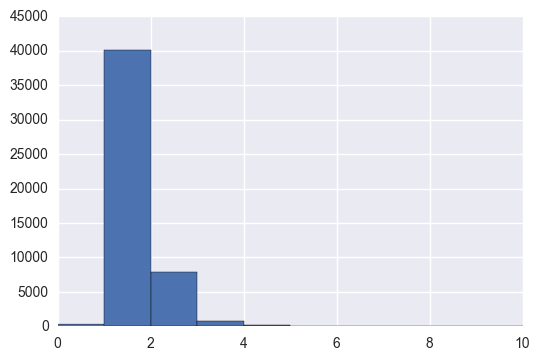

In [10]:
train_df.bathrooms.hist()

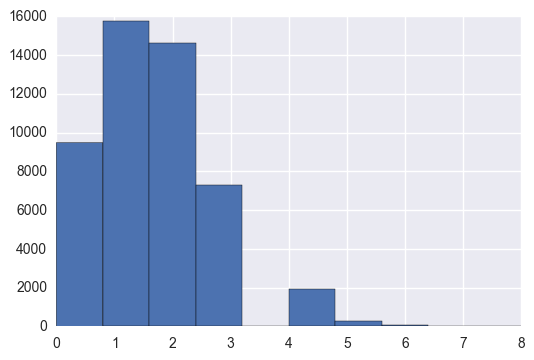

In [11]:
train_df.bedrooms.hist()

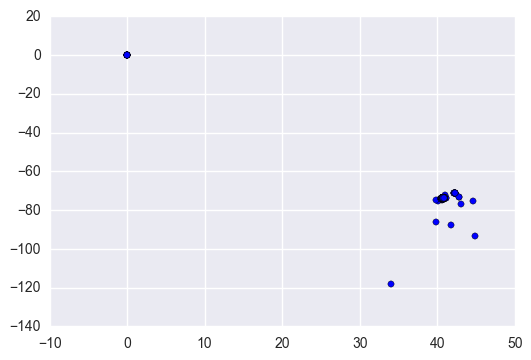

In [18]:
plt.scatter(train_df.latitude, train_df.longitude)
# we see that the 0,0 point is probably an outlier / misentry, can be a signal for poor interest

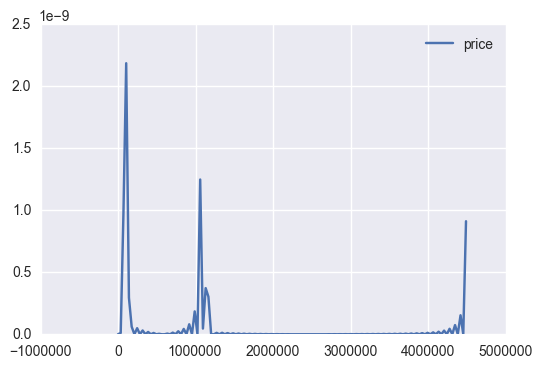

In [19]:
sns.kdeplot(train_df.price)

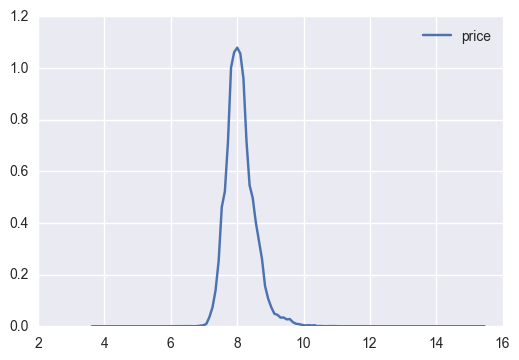

In [20]:
sns.kdeplot(np.log(train_df.price)) # the log price seems a lot more normal!

In [23]:
len(set(pd.factorize(train_df.manager_id)[0])) # there are quite a lot of managers overlaps

3481

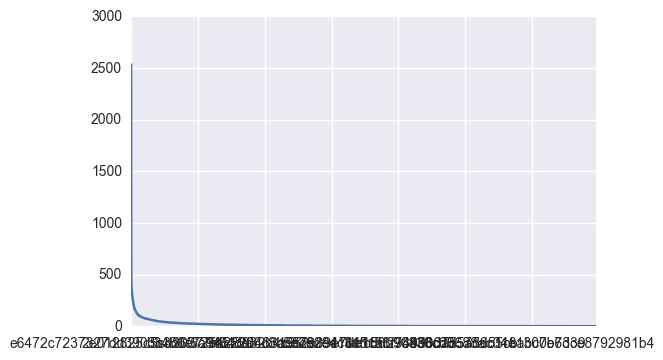

In [28]:
train_df.manager_id.value_counts().plot() # this shows that a few managers have a lot of listings but only a few

In [24]:
len(set(pd.factorize(train_df.listing_id)[0])) # one listing id per datapoint

49352

(array([ 736064.,  736078.,  736092.,  736106.,  736120.,  736134.]),
 <a list of 6 Text xticklabel objects>)

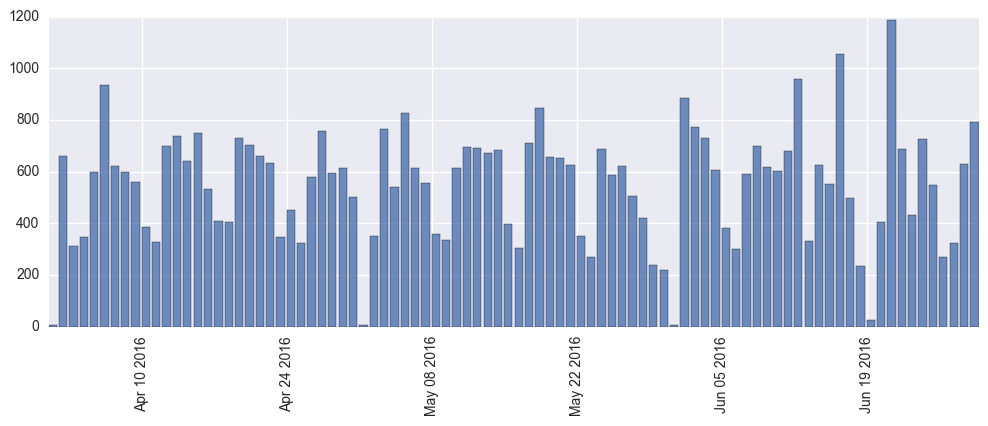

In [36]:
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["date_created"] = train_df["created"].dt.date
cnt_srs = train_df['date_created'].value_counts()

plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.bar(cnt_srs.index, cnt_srs.values, alpha=0.8)
ax.xaxis_date()
plt.xticks(rotation='vertical')

# there seems to be more listings towards the end (mid June 2016)
# there also seems to be spikes in # listings at certain time periods!! 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]), <a list of 24 Text xticklabel objects>)

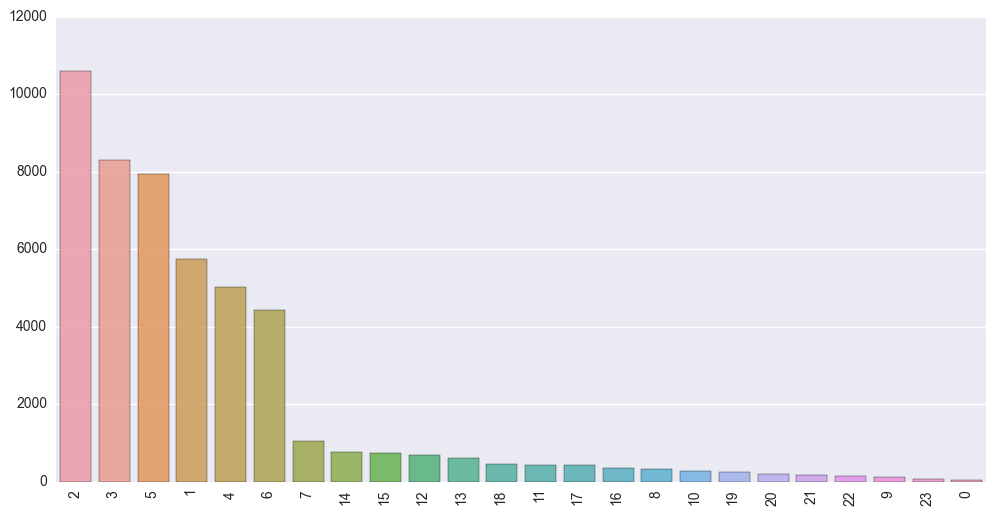

In [38]:
train_df["hour_created"] = train_df["created"].dt.hour
cnt_srs = train_df['hour_created'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')

### relationship between features

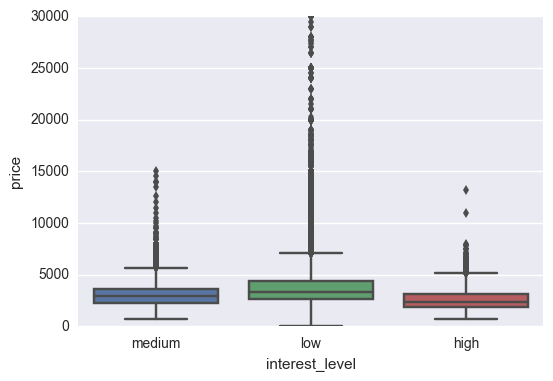

In [30]:
sns.boxplot(x='interest_level', y='price', data=train_df[train_df.price <= 30000])
# low interest is correlated with a lot of higher prices
# high interest is correlated with low prices

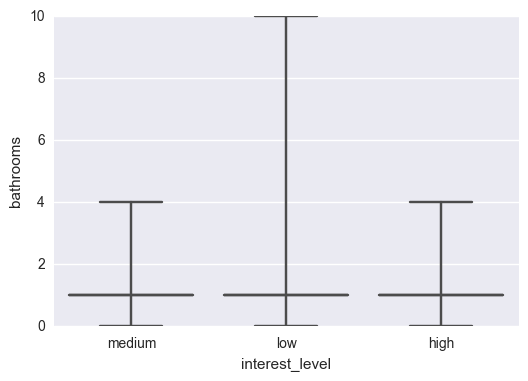

In [31]:
sns.boxplot(x='interest_level', y='bathrooms', data=train_df[train_df.price <= 30000])
# low interest in rooms with > 5 bathrooms

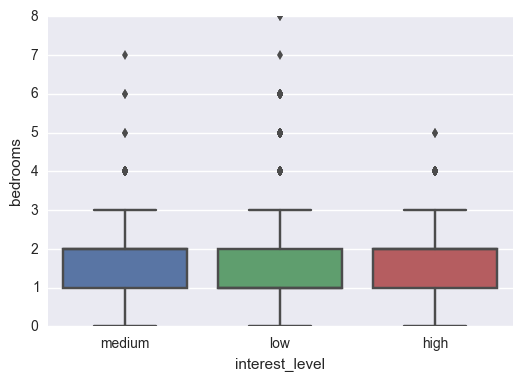

In [33]:
sns.boxplot(x='interest_level', y='bedrooms', data=train_df[train_df.price <= 30000])
# not a lot of interaction

# Data Preparation

### What steps are taken to prepare the data for modeling?
* feature transformations? engineering?

### Transforming the target into integer encoding
* Interest level (e.g. High, Medium, Low) was recoded to 0, 1, 2 for multiclass classification

In [6]:
def get_target_var(input_df):
    """
    Generate simple numeric features derived from the raw data.
    
    Args:
        input_df (pandas dataframe): A dataframe of listing data.
        
    Returns:
        A 1-D numpy array with values of the target variable (0, 1, 2) 
    """
    target_num_map = {'high':0, 'medium':1, 'low':2}
    y = np.array(input_df['interest_level'].apply(lambda x: target_num_map[x]))
    return y

### NLP Features from the Apartment Listing Description

The listing data includes an open-text field called "description". Listing authors use this field to describe the listing in their own words. Because this field contains natural text in English, we attempted to extract some features from it using common tools from Natural Language Processing pipelines.

In [7]:
def add_tfidf_features(input_df, train_df, ngram_range = (1, 2), max_features = 1000):
    """
    Extract some features from the open-text 'description' field
    using a TF-IDF vectorizer.
    
    Args:
        input_df (pandas dataframe): A dataframe of listing data.
        train_df (pandas dataframe): A dataframe of training data used \
            to fit the TF-IDF vectorizer.
        ngram_range (tuple): An integer tuple of the form (lower_bound, upper_bound) \
            used to control the behavior of the vectorizer. For example, passing \
            (1, 2) will create 1-gram and 2-gram features.
        max_features (int): The top <max_features> features from the vectorizer will be \
            preserved.
            
    Returns:
        A pandas DF identical to input_df, but with the 1000 image features appended.
    """
    
    # Fit a vectorizer
    des = TfidfVectorizer(ngram_range=ngram_range, max_features = max_features, stop_words = 'english')
    des.fit(train_df.description)
    
    # Use it to transform input_df
    tfidf_features = des.transform(input_df.description)
    
    # Create a Pandas dataframe
    colnames = ['tfidf_' + featname for featname in des.get_feature_names()]
    tfidf_features = pd.DataFrame(tfidf_features.toarray(), columns = colnames)
    
    # Append and return
    out_df = pd.concat([input_df.reset_index(), tfidf_features.reset_index()], axis = 1)
    return(out_df)

### Listing description Numerical features
* Log of price
* Number of photos
* Number of features (features are the tags provided by the listing, e.g. Doorman, Elevator, Fitness Center..etc)
* Number of words in description
* Year created
* Month created
* Day created
* Hour creaed

In [8]:
def add_numeric_features(input_df):
    """
    Generate simple numeric features derived from the raw data.
    
    Args:
        input_df (pandas dataframe): A dataframe of listing data.
    """
    input_df["log_price"] = np.log(input_df["price"])
    input_df["num_photos"] = input_df["photos"].apply(len)
    input_df["num_features"] = input_df["features"].apply(len)
    input_df["num_description_words"] = input_df["description"].apply(lambda x: len(x.split(" ")))
    input_df["created"] = pd.to_datetime(input_df["created"])
    input_df["created_year"] = input_df["created"].dt.year
    input_df["created_month"] = input_df["created"].dt.month
    input_df["created_day"] = input_df["created"].dt.day
    input_df["created_hour"] = input_df["created"].dt.hour
    return(input_df)

### Features Derived from Listing Images

We use Python's PIL library to process the provided image files into numeric matrices. Each pixel in the provided image is encoded as a 3-element tuple representing RGB (red, green, blue) values. Each color's value is referred to as a "channel" in the image processing literature and in this report

* Mean pixel value, red channel
* Mean pixel value, green channel
* Mean pixel value, blue channel
* Standard deviation of pixel values, red channel
* Standard deviation of pixel values, green channel
* Standard deviation of pixel values, blue channel
* Image resolution (total number of pixels)

In [9]:
# Define helper functions for creating image features
def parallelize_dataframe(df, func):
    num_partitions = 250 #number of partitions to split dataframe
    num_cores = 7 #number of cores on your machine
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

def append_image_features(input_df):
    img_features = input_df['photos'].map(lambda photo_album: get_image_features(photo_album))
    img_df = pd.DataFrame({
            'mean_red': np.array([feature_dict['mean_red'] for feature_dict in img_features]),
            'mean_green': np.array([feature_dict['mean_green'] for feature_dict in img_features]),
            'mean_blue': np.array([feature_dict['mean_blue'] for feature_dict in img_features]),
            'std_red': np.array([feature_dict['std_red'] for feature_dict in img_features]),
            'std_green': np.array([feature_dict['std_green'] for feature_dict in img_features]),
            'std_blue': np.array([feature_dict['std_blue'] for feature_dict in img_features]),
            'img_resolution': np.array([feature_dict['img_resolution'] for feature_dict in img_features])
        })
    return img_df

def get_image_features(photo_url_list):
    """
    Create one row of features for a collection of
    images.
    """
    
    # Write a temp file to disk to track progress
    fname = '/Users/jlamb/repos/sandbox/tmp/' + str(uuid.uuid1())
    with open(fname, 'w') as f:
        f.write('x')
    
    if len(photo_url_list) > 0:
        
        try: 
            # Set up collectors
            mean_red = []
            mean_green = []
            mean_blue = []
            std_red = []
            std_green = []
            std_blue = []
            img_resolution = []

            # TESTING: Just use first image for now
            photo_url_list = [photo_url_list[0]]
            for url in photo_url_list:

                # Get photo (http://stackoverflow.com/questions/7391945/how-do-i-read-image-data-from-a-url-in-python)
                url = url
                response = requests.get(url)
                img = np.array(Image.open(StringIO(response.content)))

                # Mean value by channel
                mean_red.append(img[:,0].mean())
                mean_green.append(img[:,1].mean())
                mean_blue.append(img[:,2].mean())

                # standard deviation by channel
                std_red.append(img[:,0].std())
                std_green.append(img[:,1].std())
                std_blue.append(img[:,2].std())

                # resolution (num pixels)
                img_resolution.append(img.size)

            # Summarize 
            out_dict = {
                'mean_red': np.mean(np.array(mean_red)),
                'mean_green': np.mean(np.array(mean_green)),
                'mean_blue': np.mean(np.array(mean_blue)),
                'std_red': np.mean(np.array(std_red)),
                'std_green': np.mean(np.array(std_green)),
                'std_blue': np.mean(np.array(std_blue)),
                'img_resolution': np.mean(np.array(img_resolution))
            }
            
        except:
            
            out_dict = {
                'mean_red': float('nan'),
                'mean_green': float('nan'),
                'mean_blue': float('nan'),
                'std_red': float('nan'),
                'std_green': float('nan'),
                'std_blue': float('nan'),
                'img_resolution': float('nan')
            }
            
        
    else:
    
        out_dict = {
            'mean_red': float('nan'),
            'mean_green': float('nan'),
            'mean_blue': float('nan'),
            'std_red': float('nan'),
            'std_green': float('nan'),
            'std_blue': float('nan'),
            'img_resolution': float('nan')
        }
        
    return(out_dict)

### Tags of the listing
Extract the tags of each listing and output as sparse matrix

In [10]:
def feature_extraction(df):
    feature_list = []
    for i in df.features:
        feature_list.extend(i)
    names = list(set(feature_list))
    voc2id = dict(zip(names, range(len(names))))
    rows, cols, vals = [], [], []
    for r, d in enumerate(df.features):
        for e in d:
            if voc2id.get(e) is not None:
                rows.append(r)
                cols.append(voc2id[e])
                vals.append(1)
    features = sp.csr_matrix((vals, (rows, cols)))
    svd = TruncatedSVD(n_components=8)
    features_svd = pd.DataFrame(svd.fit_transform(features),columns = ['f-1','f-2','f-3','f-4','f-5','f-6','f-7','f-8'])
    return features_svd

### Neighborhood features
On Renthop website the lists are segments by neighborhoods. A list of neighborhood names from the Renthop nyc website. 

The latitude and longitude of the neighborhood is gotten with the geopy.geocodes. 

The corresponding neighborhood is returned by calculated the distance between the listing building and the center of the neighborhood.

There are some wrong records in the records, which give me a location in Chicago or even farther. All listing with distance greater than 10 are therefore removed.

 There are a total of 158 neighborhoods in the Great New York Area on Renthop. They are converted to dummy variables.

In [25]:
def neighborhood(df):
    m_neighborhoods = ['Battery Park City','Bowery','Chinatown','Civic Center','East Village','Financial District',
                       'Greenwich Village','Little Italy','Lower East Side','NoHo','NoLita','SoHo','Tribeca','Two Bridges',
                       'West Village','Chelsea','Flatiron District','Garment District','Gramercy Park',"Hell's Kitchen",'Kips Bay',
                       'Koreatown','Midtown East','Murray Hill','NoMad','Stuyvesant Town - Peter Cooper Village','Theater District',
                       'Central Harlem','Central Park','East Harlem','Inwood','Upper East Side','Upper West Side',
                       'Washington Heights','West Harlem','Randalls-Wards Island','Roosevelt Island']

    b_neighborhoods = ['Bedford-Stuyvesant','Bushwick','Greenpoint','Williamsburg','Boerum Hill','Carroll Gardens','Cobble Hill',
                       'Gowanus','Greenwood Heights','Park Slope','Prospect Park','Red Hook','Sunset Park','Windsor Terrace',
                       'Crown Heights','East Flatbush','Flatbush','Kensington','Midwood','Ocean Hill','Brooklyn Heights',
                       'Brooklyn Navy Yard','Clinton Hill','DUMBO','Downtown Brooklyn','Fort Greene','Prospect Heights',
                       'Vinegar Hill','Bath Beach','Bay Ridge','Bensonhurst','Borough Park','Dyker Heights','Mapleton',
                       'Brighton Beach','Coney Island','Gravesend','Sheepshead Bay','Brownsville','Canarsie','Cypress Hills',
                       'East New York','Bergen Beach','Flatlands','Floyd Bennett Airfield','Marine Park','Mill Basin']

    q_neighborhoods = ['Astoria','Corona','East Elmhurst','Elmhurst','Forest Hills','Glendale','Jackson Heights','Long Island City',
                       'Maspeth','Middle Village','Rego Park','Ridgewood','Sunnyside','Woodside','Auburndale','Bayside',
                       'College Point','Flushing','Flushing Meadows-Corona Park','Fresh Meadows','Glen Oaks','Kew Gardens',
                       'Kew Gardens Hills','Whitestone','Briarwood','Hollis','Holliswood','Jamaica','Jamaica Estates',
                       'Jamaica Hills','South Jamaica','St. Albans','Forest Park','Howard Beach','Ozone Park','Richmond Hill',
                       'South Ozone Park','Woodhaven','Far Rockaway','Rockaway Beach']

    s_neighborhoods =  ['East Shore','Mid-Island','North Shore','South Shore']

    bx_neighborhoods = ['Bedford Park','Belmont','Bronx Park','Concourse','Concourse Village','East Tremont','Fordham Heights',
                        'Fordham Manor','Highbridge','Hunts Point','Kingsbridge','Longwood','Marble Hill','Morris Heights',
                        'Morrisania','Mott Haven','Mount Eden','Mount Hope','Norwood','Riverdale','University Heights',
                        'Van Cortlandt Park','West Farms','Allerton','Clason Point','Morris Park','Parkchester','Pelham Bay',
                        'Pelham Parkway','Throgs Neck','Unionport','Van Nest','Wakefield','Westchester Village','Williamsbridge',
                        'Woodlawn Heights']

    nj_neighborhoods = ['Bergen - Lafayette',
                        'Greenville','Historic Downtown','McGinley Square','The Heights','The Waterfront','West Side']
    neighborhood_list = ['m_neighborhoods','b_neighborhoods','q_neighborhoods','s_neighborhoods','bx_neighborhoods','nj_neighborhoods']
    n_dict = {'m_neighborhoods':'manhattan','b_neighborhoods':'brooklyn','q_neighborhoods':'queens',
          's_neighborhoods':'staten island','bx_neighborhoods':'bronx','nj_neighborhoods':'new jersey'}
    neighborhood_dict= {}
    for n_list in neighborhood_list:
        for n in eval(n_list):
            geolocator = Nominatim()
            location = geolocator.geocode(n+" "+n_dict[n_list], timeout=3)
            try:
                neighborhood_dict[n]=(location.latitude, location.longitude)
            except:
                continue
    neighborhood_dict['Nolita'] = (40.7230413,-73.9948607)
    neighborhood_dict['Two Bridges'] = (40.71074689999999,-73.99696)
    neighborhood_dict['Flatiron District'] = (40.74008300000001,-73.99034890000001)
    neighborhood_dict['Garment District'] = (40.7547072,-73.99163420000002)
    neighborhood_dict['Stuyvesant Town - Peter Cooper Village'] = (40.7316903,-73.97784939999997)
    neighborhood_dict['Randalls-Wards Island'] = (40.7932271,-73.92128579999996)
    neighborhood_dict['Floyd Bennett Airfield'] = (40.5910174,-73.8906091)
    neighborhood_dict['Jamaica Hills'] = (40.71280290000001,-73.79926339999997)
    neighborhood_dict['East Shore'] = (40.606221,-74.06419489999996)
    neighborhood_dict['Mid-Island'] = (40.5993847,-74.17931770000001)
    neighborhood_dict['North Shore'] =(40.62604414772478,-74.12667847936973)
    neighborhood_dict['South Shore'] = (40.531910867376595,-74.21559907263145)
    neighborhood_dict['Westchester Village'] = (40.8407103,-73.8473591)
    neighborhood_dict['Bergen - Lafayette'] =(40.71114639999999,-74.07407289999998)
    neighborhood_dict['Historic Downtown'] =(40.71114639999999,-74.07407289999998)
    neighborhood_dict['McGinley Square'] = (40.7241223,-74.06966729999999)
    neighborhood_dict['West Side'] =(40.7247507,-74.08288390000001)
    neighborhood_df = pd.Series(neighborhood_dict)
    dist = DistanceMetric.get_metric('euclidean')
    X = list(neighborhood_df)

    min_distance = np.zeros(df.shape[0])
    min_index = []
    count = 0
    for listing in np.array(df[['latitude','longitude']]) :   
        min_distance[count] = np.min(dist.pairwise(X,[listing]), axis = 0)
        if np.min(dist.pairwise(X,[listing]), axis = 0) < 10:
            min_index.append(neighborhood_df.index[np.argmin(dist.pairwise(X,[listing]))])
        else:
            min_index.append(np.nan)
        count += 1
    min_index = np.array(min_index)
    n_df = pd.get_dummies(min_index)
    n_df = n_df.fillna(0)
    return n_df

### Creating Modeling Base Tables

With these feature functions in hand, we can create the tables used in the modeling effort

In [26]:
# Create train, validation, full_train, and testing
# --- *_full_train = the entire training dataset (used to fit final model)
# --- *_dev_train  = training set used during model development
# --- *_dev_val    = validation data used during development
# --- *_test       = test set that we will call predict on to produce final submission

# Read in raw data
full_train = pd.read_json("train.json")
X_test  = pd.read_json("test.json")

# Add features that can be added before train-test split

# --- 1. Image features
# [training data] Apply the image processing or readin cached features
if not os.path.isfile('img_full_train.pickle'):
    img_full_train = parallelize_dataframe(full_train, append_image_features)
    pickle.dump(img_full_train, open('img_full_train.pickle', 'wb'))
else:
    with open('img_full_train.pickle', 'r') as pickle_file:
        img_full_train = pickle.load(pickle_file)
full_train = pd.concat([full_train.reset_index(), img_full_train.reset_index()], axis = 1)

# [testing data] Apply the image processing or readin cached features
if not os.path.isfile('img_test.pickle'):
    img_test = parallelize_dataframe(X_test, append_image_features)
    pickle.dump(img_test, open('img_test.pickle', 'wb'))
else:
    with open('img_test.pickle', 'r') as pickle_file:
        img_test = pickle.load(pickle_file)
X_test = pd.concat([X_test.reset_index(), img_test.reset_index()], axis = 1)

# --- 2. Numeric features
full_train = add_numeric_features(full_train)
X_test = add_numeric_features(X_test)

# --- 3 Add listing tags
features_svd_train = feature_extraction(full_train)
features_svd_test = feature_extraction(X_test)

# --- 4 Add neighborhood features

# Sometimes this needs to be retried a few times,
# server is real unreliable
try:
    n_df_train = neighborhood(full_train)
except:
    n_df_train = neighborhood(full_train)

try:
    n_df_test = neighborhood(X_test)
except:
    n_df_test = neighborhood(X_test)

frames = [full_train, features_svd_train,n_df_train]
full_train = pd.concat(frames, axis=1)

frames_test = [X_test, features_svd_test,n_df_test]
X_test = pd.concat(frames_test, axis=1)



####===== Split into X & Y =====####
Y_full_train = get_target_var(full_train)

# Split train_df into train and validation
X_dev_train, X_dev_val, Y_dev_train, Y_dev_val = train_test_split(full_train, Y_full_train, test_size=0.33)

# Add NLP features
X_dev_train = add_tfidf_features(X_dev_train, X_dev_train, ngram_range = (1,2), max_features = 1000)
X_dev_val = add_tfidf_features(X_dev_val, X_dev_train, ngram_range = (1,2), max_features = 1000)
X_test = add_tfidf_features(X_test, full_train, ngram_range = (1,2), max_features = 1000)

### Precise description of modeling base tables.
* What are the rows/columns of X (the predictors)?
* Target variable:
    - *interest_level (categorical)*: A three-level categorical variable. Encoded as 0, 1, 2 corresponding with levels "low", "medium" and "high" interest

# Modeling

### What model are we using? Why?
### Assumptions?
### Regularization?

In [39]:
# oh we should prob remember to whiten the data w/ standard scaler

# Evaluation

### How well does the model perform?

In [ ]:
# logloss

In [ ]:
# accuracy

# Deployment

Implementing a deployed analytic is outside the scope of this exercise. The answers below are hypothetical only.

### How is the model deployed?
* To be deployed at RentHop, it's likely that the model would need to be deployed as a standalone microservice which can be managed by Operational personnell. Regardless of the exact technology used, the application should expect to receive a JSON payload with raw listing details and should produce a small JSON objects with probabilities for each class ('low', 'medium', 'high'). We see a few possible configurations that could support such an app:
    1. All-Python app (e.g. Flask) listening for POST requests with listing data
    2. Containerized Python app (e.g. in Docker) in a container which also runs a web server
    3. Python model rewritten in Java by engineers

### What support is provided after initial deployment?
* Model results will be tracked by nightly batch jobs to try to catch eroding environmental fit
* The model may need to be updated periodically to refelect a changing renatl environment or to incorporate new data sources